In [2]:
from sklearn.linear_model import LogisticRegression
import pandas as pd 
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

X = pd.read_pickle("X.pkl")
features = X.columns
y = pd.read_pickle("y.pkl")
y = np.ravel(y)
print(y)

print(features)

[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking'],
      dtype='object')


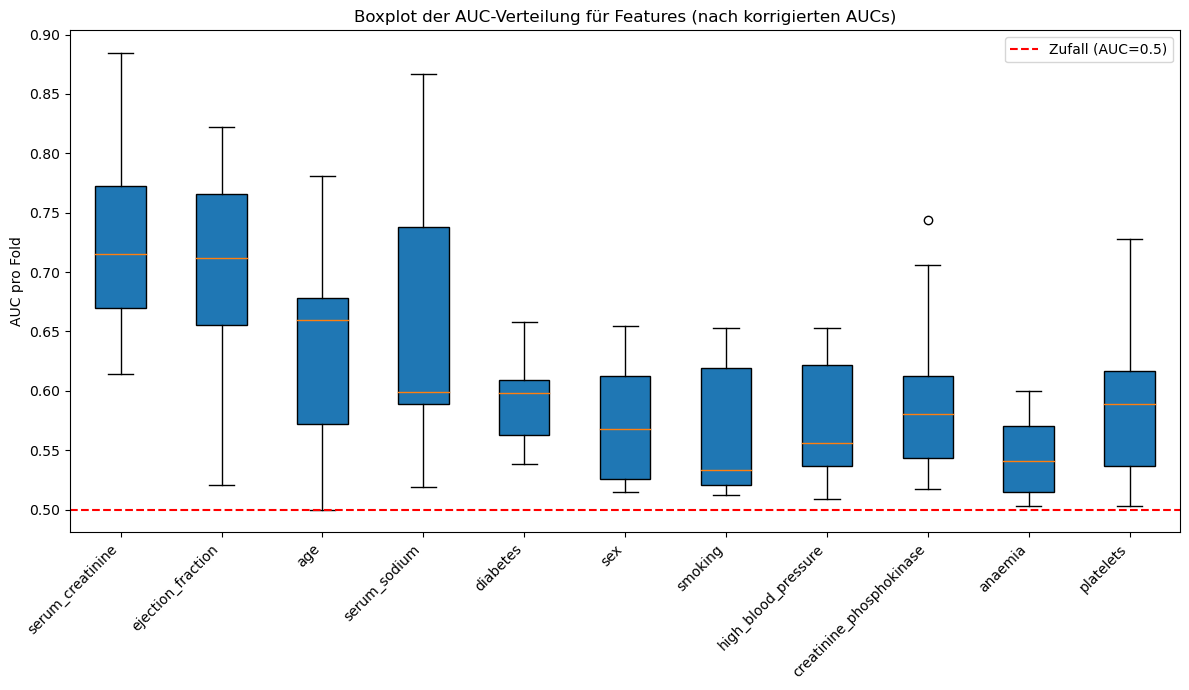

In [3]:
feature_auc_scores = {}
feature_all_auc_scores = {}
cv = StratifiedKFold(n_splits=10, shuffle = True,random_state=1)

for feature in features:
    model = LogisticRegression()
    auc_scores = cross_val_score(
        model, X[[feature]], y,
        cv=cv,  # 5-fold cross-validation
        scoring='roc_auc'
    )

    # Mittelwert speichern
    auc_score = np.mean(auc_scores)
    if auc_score < 0.5:
        auc_score = 1 - auc_score
    feature_auc_scores[feature] = auc_score
    feature_all_auc_scores[feature] = np.where(auc_scores < 0.5, 1 - auc_scores, auc_scores)
    
sorted_features = sorted(feature_auc_scores.items(), key=lambda x: x[1], reverse=True)
top_features = [f for f, _ in sorted_features]  # alle Features sortiert

# Boxplot-Daten vorbereiten (alle Features)
boxplot_data = [feature_all_auc_scores[f] for f in top_features]

# Plot
plt.figure(figsize=(12, 7))
plt.boxplot(boxplot_data, labels=top_features, patch_artist=True)
plt.xticks(rotation=45, ha='right')
plt.axhline(0.5, color='red', linestyle='--', label='Zufall (AUC=0.5)')
plt.ylabel("AUC pro Fold")
plt.title("Boxplot der AUC-Verteilung für Features (nach korrigierten AUCs)")
plt.legend()
plt.tight_layout()
plt.show()

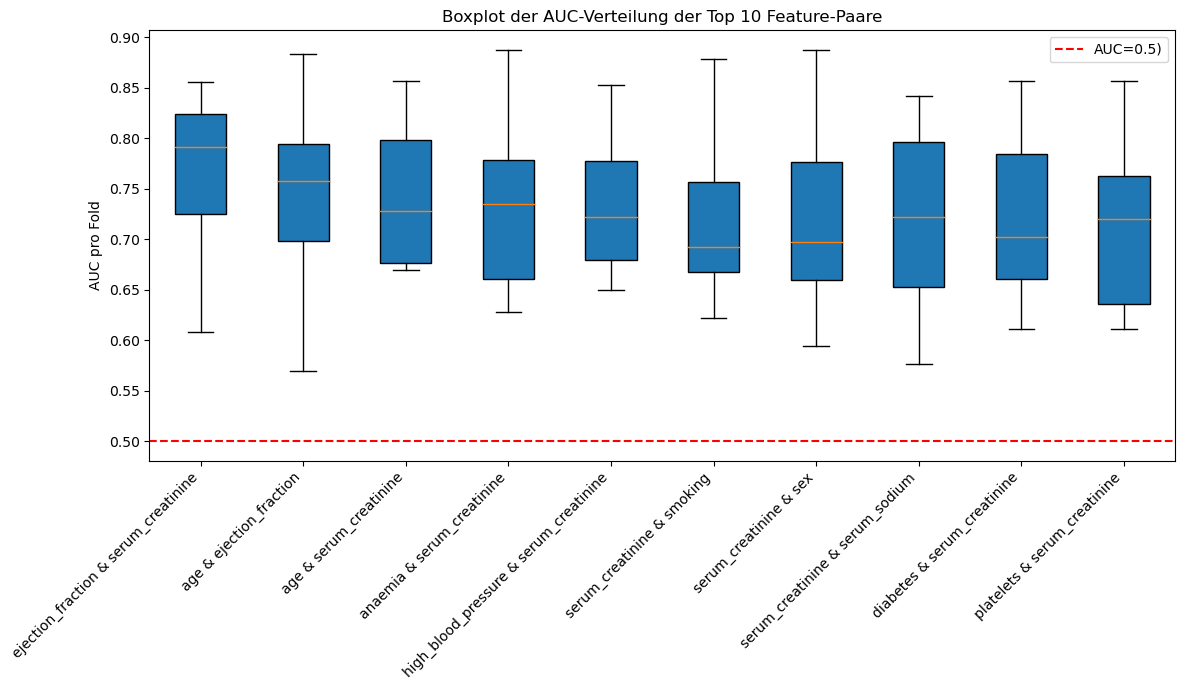

In [4]:
import itertools

feature_pairs = list(itertools.combinations(X.columns, 2))
pair_all_auc_scores = {}
pair_auc_scores = {}

for feature in feature_pairs:
    model = LogisticRegression()
    auc_scores = cross_val_score(
        model, X[list(feature)], y,
        cv=cv, 
        scoring='roc_auc'
    )

    auc_score = np.mean(auc_scores)
    pair_all_auc_scores[feature] = auc_scores
    pair_auc_scores[feature] = auc_score
    
sorted_pairs = sorted(pair_auc_scores.items(), key=lambda x: x[1], reverse=True)

# Hole Top 10 (oder alle, je nach Wunsch)
top_n = 10
top_pairs = [pair for pair, _ in sorted_pairs[:top_n]]

# Hole AUC-Werte pro Fold für Top Paare
boxplot_data = [pair_all_auc_scores[pair] for pair in top_pairs]
labels = [f"{p[0]} & {p[1]}" for p in top_pairs]

# Plot
plt.figure(figsize=(12, 7))
plt.boxplot(boxplot_data, labels=labels, patch_artist=True)
plt.xticks(rotation=45, ha='right')
plt.axhline(0.5, color='red', linestyle='--', label='AUC=0.5)')
plt.ylabel("AUC pro Fold")
plt.title(f"Boxplot der AUC-Verteilung der Top {top_n} Feature-Paare")
plt.legend()
plt.tight_layout()
plt.show()

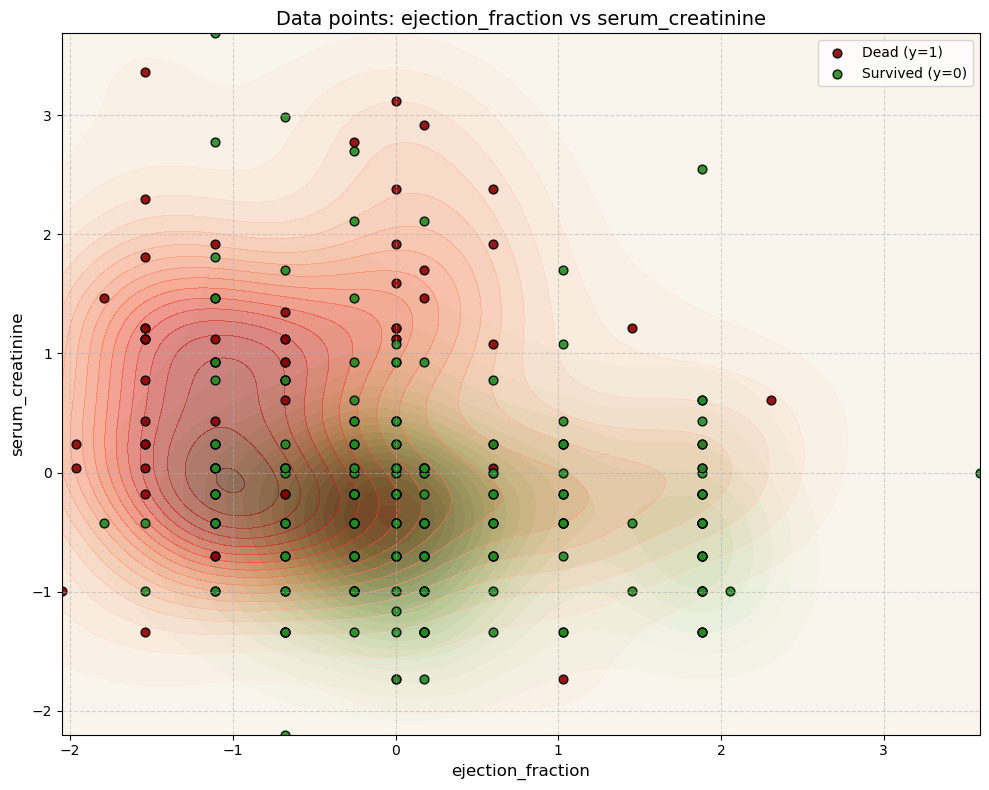

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


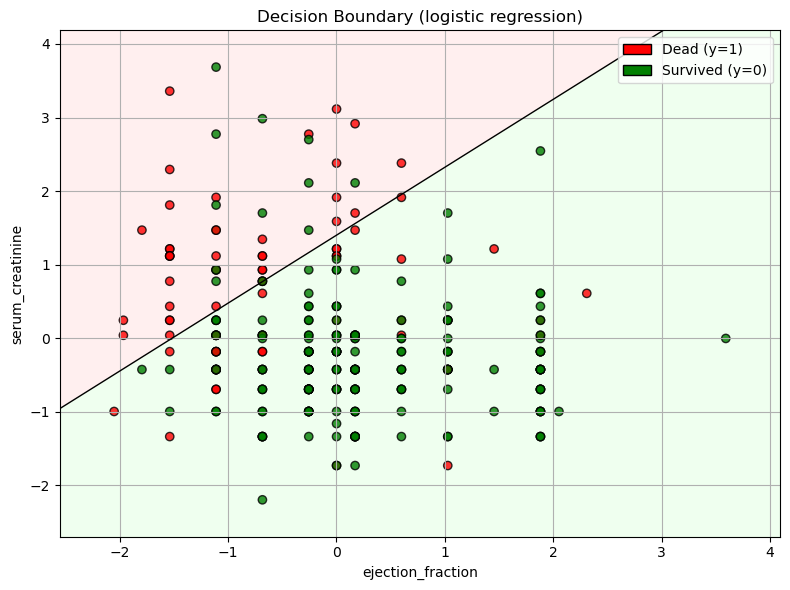

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.stats import gaussian_kde

# Zwei Features
feature_x = 'ejection_fraction'
feature_y = 'serum_creatinine'

# Daten
x_vals = X[feature_x].values
y_vals = X[feature_y].values
labels = y.ravel()  # sicherstellen, dass es ein 1D-Array ist

# Klassenmasken
mask_0 = labels == 0
mask_1 = labels == 1

# Grid für KDE
xgrid = np.linspace(x_vals.min(), x_vals.max(), 200)
ygrid = np.linspace(y_vals.min(), y_vals.max(), 200)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
grid_coords = np.vstack([Xgrid.ravel(), Ygrid.ravel()])

# Plot starten
plt.figure(figsize=(10, 8))

# KDE für Klasse 0 (rot)
if np.sum(mask_0) >= 2:
    xy0 = np.vstack([x_vals[mask_0], y_vals[mask_0]])
    kde0 = gaussian_kde(xy0)
    Z0 = kde0(grid_coords).reshape(Xgrid.shape)
    plt.contourf(Xgrid, Ygrid, Z0, levels=20, cmap='Greens')

# KDE für Klasse 1 (grün)
if np.sum(mask_1) >= 2:
    xy1 = np.vstack([x_vals[mask_1], y_vals[mask_1]])
    kde1 = gaussian_kde(xy1)
    Z1 = kde1(grid_coords).reshape(Xgrid.shape)
    plt.contourf(Xgrid, Ygrid, Z1, levels=20, cmap='Reds', alpha=0.5)

# Punkte plotten
plt.scatter(x_vals[mask_1], y_vals[mask_1], c='darkred', edgecolor='k', s=40, label='Dead (y=1)', alpha=0.9)
plt.scatter(x_vals[mask_0], y_vals[mask_0], c='forestgreen', edgecolor='k', s=40, label='Survived (y=0)', alpha=0.9)

# Styling
plt.xlabel(feature_x, fontsize=12)
plt.ylabel(feature_y, fontsize=12)
plt.title(f'Data points: {feature_x} vs {feature_y}', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



# Zwei Features auswählen
X_2d = X[[feature_x, feature_y]]

# Modell trainieren
model = LogisticRegression()
model.fit(X_2d, y)

# Gitter für den Hintergrund erzeugen
x_min, x_max = X_2d[feature_x].min() - 0.5, X_2d[feature_x].max() + 0.5
y_min, y_max = X_2d[feature_y].min() - 0.5, X_2d[feature_y].max() + 0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 500),
    np.linspace(y_min, y_max, 500)
)

# Vorhersage auf dem Gitter
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

# Farben der Punkte je nach y
colors = y.map({1: 'red', 0: 'green'}) if hasattr(y, 'map') else np.where(y == 0, 'green', 'red')

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], colors=['#ccffcc', '#ffcccc'], alpha=0.3)
plt.contour(xx, yy, probs, levels=[0.5], colors='black', linewidths=1)

# Punkte plotten
plt.scatter(X_2d[feature_x], X_2d[feature_y], c=colors, edgecolor='k', alpha=0.8)

# Achsen & Titel
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.title("Decision Boundary (logistic regression)")

# Legende
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', edgecolor='k', label='Dead (y=1)'),
    Patch(facecolor='green', edgecolor='k', label='Survived (y=0)'),
]
plt.legend(handles=legend_elements)

plt.grid(True)
plt.tight_layout()
plt.show()

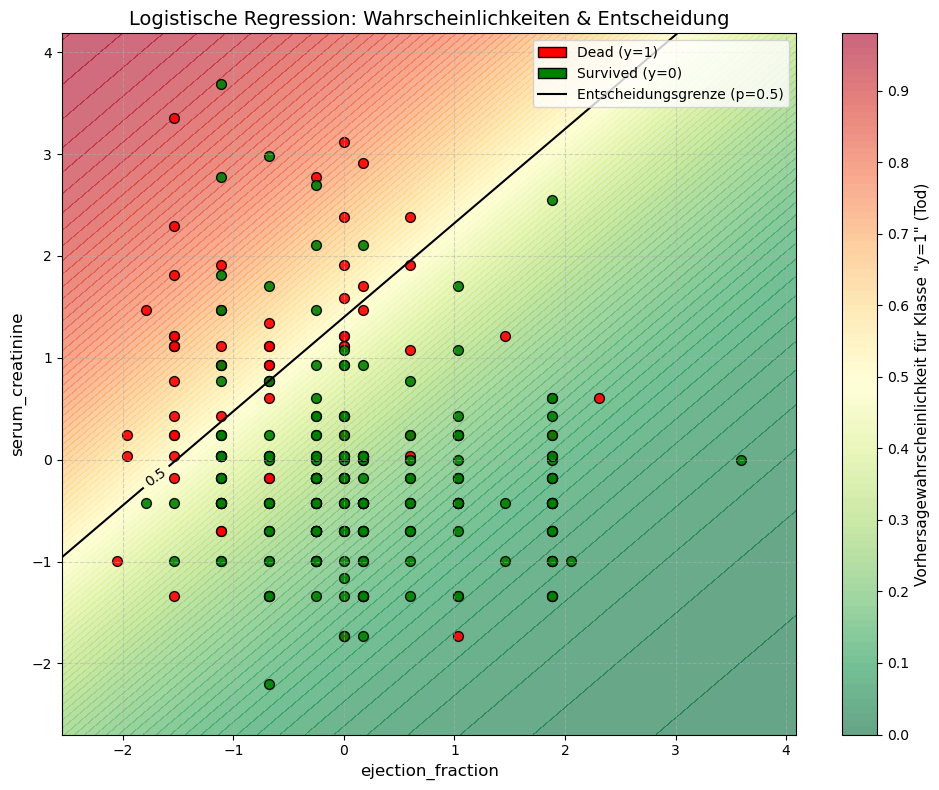

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.linear_model import LogisticRegression

# Features wählen
feature_x = 'ejection_fraction'
feature_y = 'serum_creatinine'

# 2D-Daten extrahieren
X_2d = X[[feature_x, feature_y]].values
x_vals = X[feature_x].values
y_vals = X[feature_y].values

# Modell trainieren
model = LogisticRegression()
model.fit(X_2d, y)

# Gitter für Hintergrundwahrscheinlichkeiten
x_min, x_max = x_vals.min() - 0.5, x_vals.max() + 0.5
y_min, y_max = y_vals.min() - 0.5, y_vals.max() + 0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 500),
    np.linspace(y_min, y_max, 500)
)
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

# Farben für die Punkte: y=1 → rot, y=0 → grün
point_colors = np.where(y == 1, 'red', 'green')

# Plot
plt.figure(figsize=(10, 8))

# Farbfläche mit kontinuierlicher Sigmoid-Wahrscheinlichkeit (y=1)
contour = plt.contourf(xx, yy, probs, levels=100, cmap="RdYlGn_r", alpha=0.6)

# Entscheidungsgrenze (0.5)
decision_line = plt.contour(xx, yy, probs, levels=[0.5], colors='black', linewidths=1.5)
plt.clabel(decision_line, inline=True, fontsize=10)

# Datenpunkte plotten
plt.scatter(x_vals[y == 1], y_vals[y == 1], c='red', edgecolor='k', s=50, label='Dead (y=1)', alpha=0.9)
plt.scatter(x_vals[y == 0], y_vals[y == 0], c='green', edgecolor='k', s=50, label='Survived (y=0)', alpha=0.9)

# Achsen & Titel
plt.xlabel(feature_x, fontsize=12)
plt.ylabel(feature_y, fontsize=12)
plt.title("Logistische Regression: Wahrscheinlichkeiten & Entscheidung", fontsize=14)

# Farbskala hinzufügen
cbar = plt.colorbar(contour)
cbar.set_label('Vorhersagewahrscheinlichkeit für Klasse "y=1" (Tod)', fontsize=11)

# Legende für Punkte & Entscheidung
legend_elements = [
    Patch(facecolor='red', edgecolor='k', label='Dead (y=1)'),
    Patch(facecolor='green', edgecolor='k', label='Survived (y=0)'),
    Line2D([0], [0], color='black', lw=1.5, label='Entscheidungsgrenze (p=0.5)')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


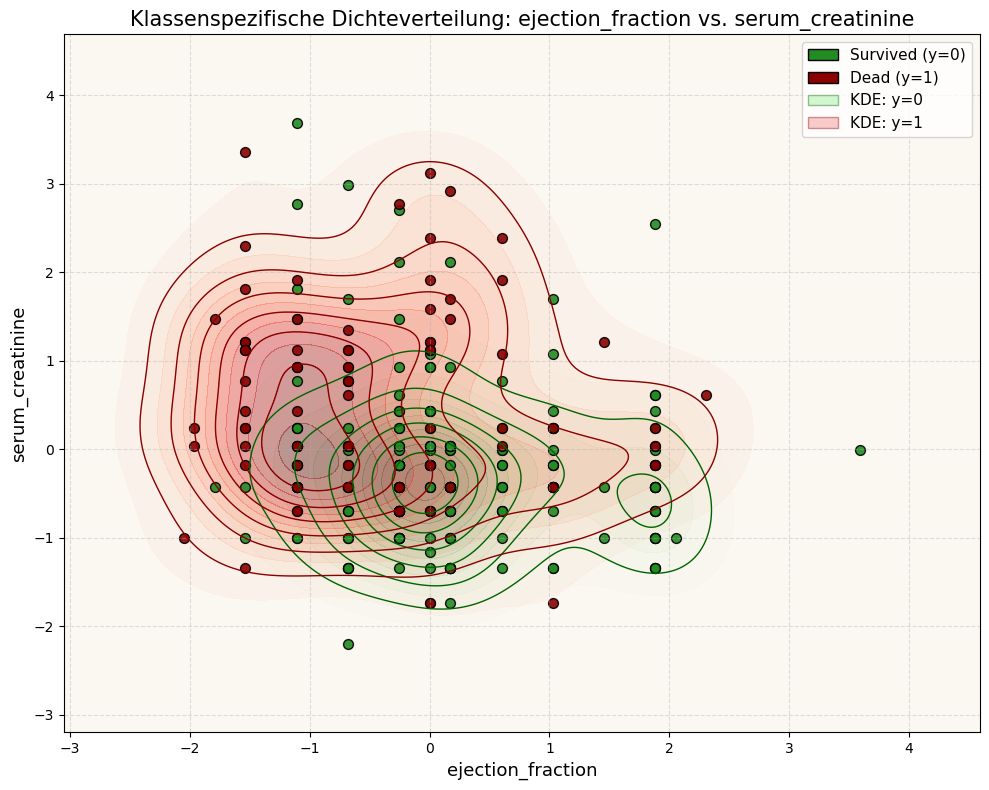

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.stats import gaussian_kde

# Zwei Features
feature_x = 'ejection_fraction'
feature_y = 'serum_creatinine'

# Daten
x_vals = X[feature_x].values
y_vals = X[feature_y].values
labels = y.ravel()

# Klassenmasken
mask_0 = labels == 0
mask_1 = labels == 1

# Grid für KDE
xgrid = np.linspace(x_vals.min() - 1, x_vals.max() + 1, 300)
ygrid = np.linspace(y_vals.min() - 1, y_vals.max() + 1, 300)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
grid_coords = np.vstack([Xgrid.ravel(), Ygrid.ravel()])

# Plot starten
plt.figure(figsize=(10, 8))

# KDE für Klasse 0
if np.sum(mask_0) >= 2:
    xy0 = np.vstack([x_vals[mask_0], y_vals[mask_0]])
    kde0 = gaussian_kde(xy0)
    Z0 = kde0(grid_coords).reshape(Xgrid.shape)
    plt.contourf(Xgrid, Ygrid, Z0, levels=15, cmap='Greens', alpha=0.4)
    plt.contour(Xgrid, Ygrid, Z0, levels=6, colors='darkgreen', linewidths=1)

# KDE für Klasse 1
if np.sum(mask_1) >= 2:
    xy1 = np.vstack([x_vals[mask_1], y_vals[mask_1]])
    kde1 = gaussian_kde(xy1)
    Z1 = kde1(grid_coords).reshape(Xgrid.shape)
    plt.contourf(Xgrid, Ygrid, Z1, levels=15, cmap='Reds', alpha=0.4)
    plt.contour(Xgrid, Ygrid, Z1, levels=6, colors='darkred', linewidths=1)

# Datenpunkte plotten
plt.scatter(x_vals[mask_0], y_vals[mask_0], c='forestgreen', edgecolor='k', s=50, label='Survived (y=0)', alpha=0.9)
plt.scatter(x_vals[mask_1], y_vals[mask_1], c='darkred', edgecolor='k', s=50, label='Dead (y=1)', alpha=0.9)

# Achsen & Titel
plt.xlabel(feature_x, fontsize=13)
plt.ylabel(feature_y, fontsize=13)
plt.title(f'Klassenspezifische Dichteverteilung: {feature_x} vs. {feature_y}', fontsize=15)

# Legende
legend_elements = [
    Patch(facecolor='forestgreen', edgecolor='k', label='Survived (y=0)'),
    Patch(facecolor='darkred', edgecolor='k', label='Dead (y=1)'),
    Patch(facecolor='lightgreen', edgecolor='darkgreen', label='KDE: y=0', alpha=0.4),
    Patch(facecolor='lightcoral', edgecolor='darkred', label='KDE: y=1', alpha=0.4),
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=11)

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
